<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session5/EVA4S5F1_BaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


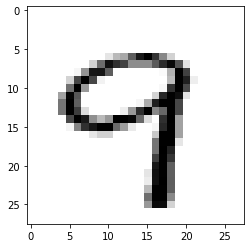

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

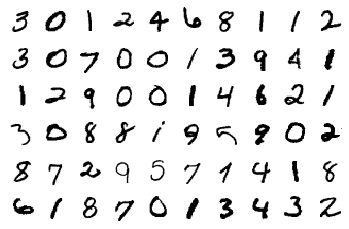

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
# Build the neural network, expand on top of nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution block-1
        self.conv_blk1 = nn.Sequential(
            # input layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),   #Output: 16X26X26, Jin=1, GRF: 3X3
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0,  bias=False),  #Output: 32X24X24, Jin=1, GRF: 5X5
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0,  bias=False),  #Output: 64X22X22, Jin=1, GRF: 7X7
            nn.ReLU()
        )

        # Transition Layer for Convolution block-1
        self.conv_blk1_transition = nn.Sequential(
            nn.MaxPool2d(2, 2),                                                                       #Output: 64X11X11, Jin=1, GRF: 8X8
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0,  bias=False),   #Output: 16X11X11 , Jin=2, GRF: 8X8 (combining channels)
        )

        # Convolution block-2
        self.conv_blk2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0,  bias=False),  #Output: 32X9X9,  Jin=2, GRF: 12X12
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0,  bias=False),  #Output: 64X7X7, Jin=2, GRF: 16X16
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0,  bias=False), #Output: 128X5X5, Jin=2, GRF: 20X20
            nn.ReLU()
        )

        # Output Block
        self.output_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),                                                              #Output: 128X1X1, Jin=2, GRF: 28X28
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0,  bias=False),  #Output: 10X1X1, Jin=2,  GRF: 28X28 combining to 10 channels as we need 10 classes for predictions
            # no ReLU for last covv layer
        ) # output_size = 1

    def forward(self, x):

        x = self.conv_blk1(x) # convolution block-1
        x = self.conv_blk1_transition(x)

        x = self.conv_blk2(x) # convolution block-2

        # output 
        x = self.output_block(x) # 

        # flatten the tensor so it can be passed to the dense layer afterward
        x = x.view(-1, 10)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           1,024
            Conv2d-9             [-1, 32, 9, 9]           4,608
             ReLU-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 64, 7, 7]          18,432
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 5, 5]          73,728
             ReLU-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.2913811206817627 Batch_id=468 Accuracy=15.54: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4114, Accuracy: 4712/10000 (47.12%)

EPOCH: 1


Loss=0.33609291911125183 Batch_id=468 Accuracy=81.60: 100%|██████████| 469/469 [00:10<00:00, 42.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2088, Accuracy: 9362/10000 (93.62%)

EPOCH: 2


Loss=0.10512059926986694 Batch_id=468 Accuracy=94.91: 100%|██████████| 469/469 [00:10<00:00, 45.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0978, Accuracy: 9707/10000 (97.07%)

EPOCH: 3


Loss=0.03490936756134033 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:10<00:00, 42.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0898, Accuracy: 9727/10000 (97.27%)

EPOCH: 4


Loss=0.04113564267754555 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:10<00:00, 47.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9768/10000 (97.68%)

EPOCH: 5


Loss=0.06524556130170822 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:10<00:00, 43.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Loss=0.07815870642662048 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:10<00:00, 43.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9820/10000 (98.20%)

EPOCH: 7


Loss=0.06255816668272018 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:10<00:00, 44.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9802/10000 (98.02%)

EPOCH: 8


Loss=0.06267640739679337 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 48.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9853/10000 (98.53%)

EPOCH: 9


Loss=0.009530683048069477 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:10<00:00, 44.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9861/10000 (98.61%)

EPOCH: 10


Loss=0.021171947941184044 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:10<00:00, 43.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9850/10000 (98.50%)

EPOCH: 11


Loss=0.007160559296607971 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 44.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9816/10000 (98.16%)

EPOCH: 12


Loss=0.012925122864544392 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:10<00:00, 44.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9883/10000 (98.83%)

EPOCH: 13


Loss=0.02869577705860138 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 44.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Loss=0.01542729139328003 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s]



Test set: Average loss: 0.0535, Accuracy: 9850/10000 (98.50%)



Text(0.5, 1.0, 'Test Accuracy')

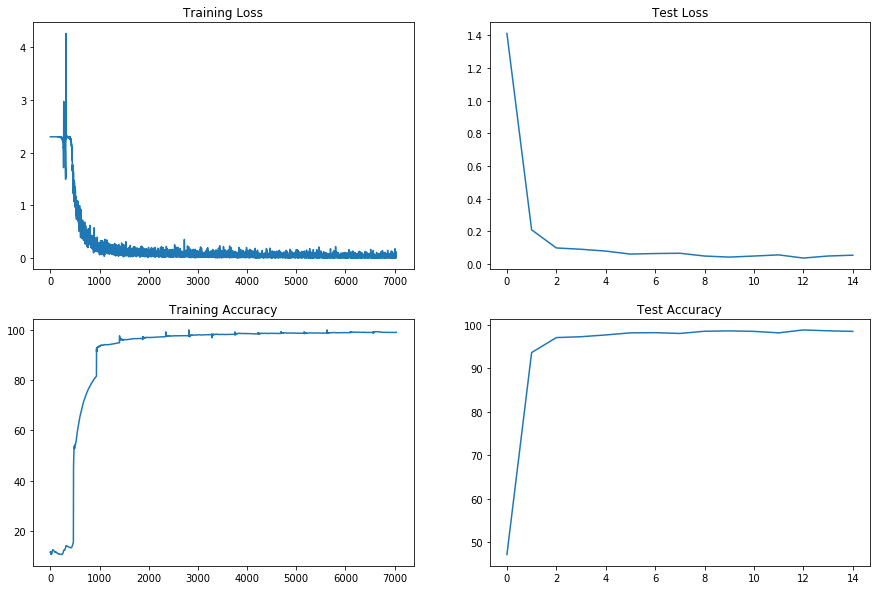

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")